In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [2]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

In [3]:
class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [4]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [5]:
def normalize(x, m, s): 
    return (x-m)/s

In [6]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        #self.fc = (32, 1500*120)
        #self.fc = (1500, 120)
        # data size = 32, 1500, 120
        #set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)] 
        print(self.layers)       
    def __call__(self, x):
        for k in self.layers:
            x = k(x)
        return x

In [7]:
def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    correct = ((predictions >=0.5) == true_values)
    return correct.mean().item()

    precision=np.array([])
    for i in range(len(y)) :
        predictions=yhat[i].detach().numpy()
        true_values=y[i].detach().numpy()
        predictions=np.where(predictions <= 0.5, 0, 1)
        correct = (predictions == true_values)
        precision=np.append(precision,correct.mean().item())
    return np.mean(precision)

def M_loss_func(yhat,y):
    predictions = yhat
    true_values = y
    return torch.where(true_values==1, 1-predictions, predictions).mean()


learing rate : .001/3/3/3  -> (tensor(-0.8370, grad_fn=<MeanBackward0>), 0.7207684659090909)

In [8]:
batch=32
lr = 0.2#.001/3/3/3 
nh = 50
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

In [9]:
d,l =next(iter(train))
c = l.max()
k, m=d[1].size()

In [10]:
model = Model(m, nh, l.size(dim=2)) #model = Model(120, nh, l.size(dim=2))
preds = model(d)

[Linear(in_features=120, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=88, bias=True)]


In [13]:
loss = M_loss_func(preds, l)
acc = M_accuracy(preds, l)
loss , acc

(tensor(0.1057, grad_fn=<MeanBackward0>), 0.5618892045454545)

## loop

In [11]:
batch = 32
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

losses, metrics = [], []
epoch = train.__len__()
lr=.001

In [12]:
from torch.utils.data import DataLoader
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
epoch = train.__len__()

In [13]:
def get_epoch(k):
    losses, metrics = [], []
    print("epoch\t","\t loss \tacc")
    for i in range(0,k):
        train_epoch()
        print(i,"\t",loss,"\t",acc)

def train_epoch():
    xb,yb =next(iter(train))
    yhatb = model(xb)
    loss = M_loss_func(yhatb, yb)
    acc = M_accuracy(yhatb, yb)
    
    losses.append(loss); metrics.append(acc)
        
    # Backpropagation
    loss.backward()

    # Update Wight and Bias with SGD
    with torch.no_grad():
        for l in model.layers:
            if hasattr(l, 'weight'):
                l.weight -= l.weight.grad * lr
                l.bias   -= l.bias.grad * lr 
                l.weight.grad.zero_()
                #l.weight.step()
                l.bias.grad.zero_()
                #l.bias.step()

In [ ]:
get_epoch(epoch)

In [14]:
print("batch\tloss\tacc.")
#optimizer=optim.SGD([loss, acc], lr=0.1)

for e in range(0,epoch) :
    for b in range(0,batch):
        # Feedforward
        xb,yb =next(iter(train))
        yhatb = model(xb)
        loss = M_loss_func(yhatb, yb)
        # Metrics
        acc = M_accuracy(yhatb, yb)
        losses.append(loss); metrics.append(acc)
        
        # Backpropagation
        loss.backward()

        # Update Wight and Bias with SGD
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad * lr 
                    l.weight.grad.zero_()
                    #l.weight.step()
                    l.bias.grad.zero_()
                    #l.bias.step()
    print(e,"\t",loss,"\t",acc)

batch	loss	acc.
0 	 tensor(-0.6037, grad_fn=<MeanBackward0>) 	 0.732216856060606
1 	 tensor(-1.3154, grad_fn=<MeanBackward0>) 	 0.7674190340909091
2 	 tensor(-2.1997, grad_fn=<MeanBackward0>) 	 0.817290009469697
3 	 tensor(-3.8776, grad_fn=<MeanBackward0>) 	 0.8535828598484848
4 	 tensor(-6.1445, grad_fn=<MeanBackward0>) 	 0.8882563920454546
5 	 tensor(-10.0363, grad_fn=<MeanBackward0>) 	 0.9103080018939393
6 	 tensor(-16.6251, grad_fn=<MeanBackward0>) 	 0.9562485795454545
7 	 tensor(-26.8980, grad_fn=<MeanBackward0>) 	 0.9641126893939393
8 	 tensor(-44.1784, grad_fn=<MeanBackward0>) 	 0.9641107954545455
9 	 tensor(-66.0680, grad_fn=<MeanBackward0>) 	 0.9661910511363636
10 	 tensor(-117.6178, grad_fn=<MeanBackward0>) 	 0.9653967803030303
11 	 tensor(-179.2612, grad_fn=<MeanBackward0>) 	 0.9649822443181818
12 	 tensor(-283.4868, grad_fn=<MeanBackward0>) 	 0.9646077178030303
13 	 tensor(-472.3953, grad_fn=<MeanBackward0>) 	 0.9645340909090909
14 	 tensor(-761.5257, grad_fn=<MeanBackward0

In [15]:
temp_l, temp_acc=[],[]
for k in losses :
    temp_l.append(k.detach())
    #temp_l.append(k)

for k in metrics :
    #temp_acc.append(k.detach())
    temp_acc.append(k)

In [16]:
len(losses)

1824

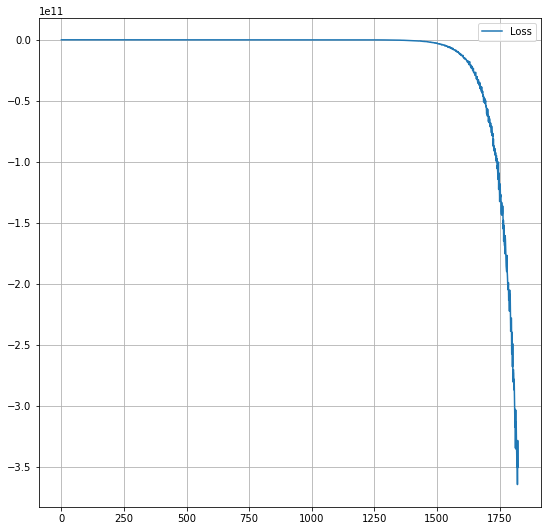

In [17]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_l, label="Loss")
ax.legend(loc='upper right')

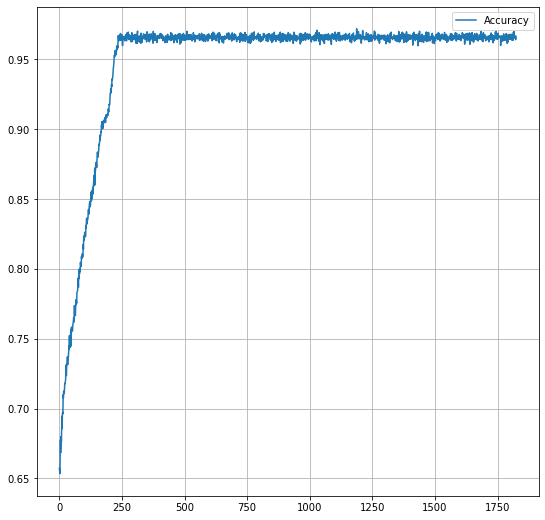

In [18]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_acc, label="Accuracy")
ax.legend(loc='upper right')

In [19]:
losses[-1], metrics[-1]

(tensor(-3.5043e+11, grad_fn=<MeanBackward0>), 0.9661811079545455)